# ASSIGNMENT 3 : BIRD CLASSIFICATION

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = './drive/MyDrive/recvis/'

In [ ]:
import numpy as np
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

from tqdm import tqdm
import PIL.Image as Image

if not os.path.isdir('./experiments'):
    os.makedirs('./experiments')
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
use_cuda = True
batch_size = 20
epochs = 30

# Data Loading 

In [ ]:
ls

drive/  experiments/  sample_data/


In [ ]:
data_transforms = transforms.Compose([
    transforms.Resize((256, 256), Image.BILINEAR),
    transforms.ToTensor(),
    
])

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(path + 'bird_dataset/train_images', transform=data_transforms),
    batch_size=batch_size, shuffle=True, num_workers=1)

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(path + 'bird_dataset/val_images',transform=data_transforms),
    batch_size=batch_size, shuffle=True, num_workers=1)

test_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(path + 'bird_dataset/test_images',transform=data_transforms),
    batch_size=1, shuffle=False, num_workers=1)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


# Visualise Data 


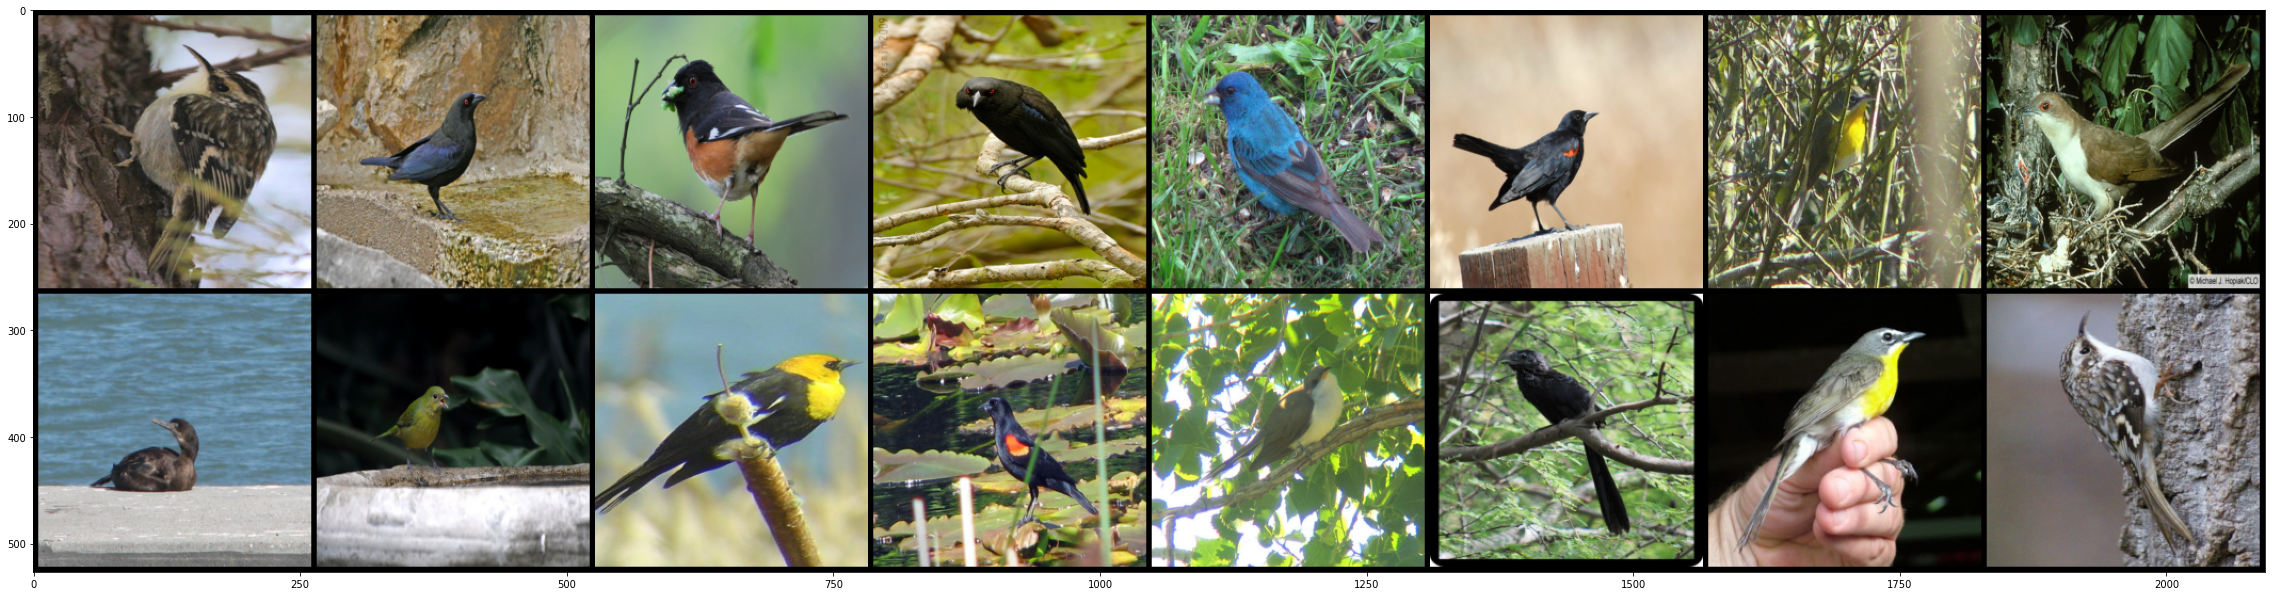

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
fig = plt.figure(figsize = (40,15))
imshow(torchvision.utils.make_grid(images[0:16], padding=5))

# Data Augmentation

In [ ]:
import imgaug as ia
import imgaug.augmenters as iaa

In [ ]:
class augmentationTransform:
  """
  Class to use augmentation from the library imgaug.
  """
  def __init__(self):
    self.aug = iaa.Sequential([
        iaa.Sometimes(0.3, iaa.GaussianBlur(sigma=(0.5, 2.0))),
        iaa.Sometimes(0.3, iaa.CoarseDropout(0.3, size_percent=0.2))
        ])

  def __call__(self, img):
    img = np.array(img)
    return self.aug.augment_image(img)

# once the images are loaded, how do we pre-process them before being passed into the network
# by default, we resize the images to 256 x 256 in size
# and normalize them to mean = 0 and standard-deviation = 1 based on statistics collected from
# the training set
data_transforms = transforms.Compose([
    augmentationTransform(),
    transforms.ToPILImage(),
    transforms.Resize(((256, 256))),
    transforms.RandomHorizontalFlip(0.3),
    transforms.RandomVerticalFlip(0.3),
    transforms.RandomAdjustSharpness(0.7, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(path + 'bird_dataset/train_images', transform=data_transforms),
    batch_size=batch_size, shuffle=True, num_workers=1)

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(path + 'bird_dataset/val_images',transform=data_transforms),
    batch_size=batch_size, shuffle=True, num_workers=1)

test_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(path + 'bird_dataset/test_images',transform=data_transforms),
    batch_size=1, shuffle=False, num_workers=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


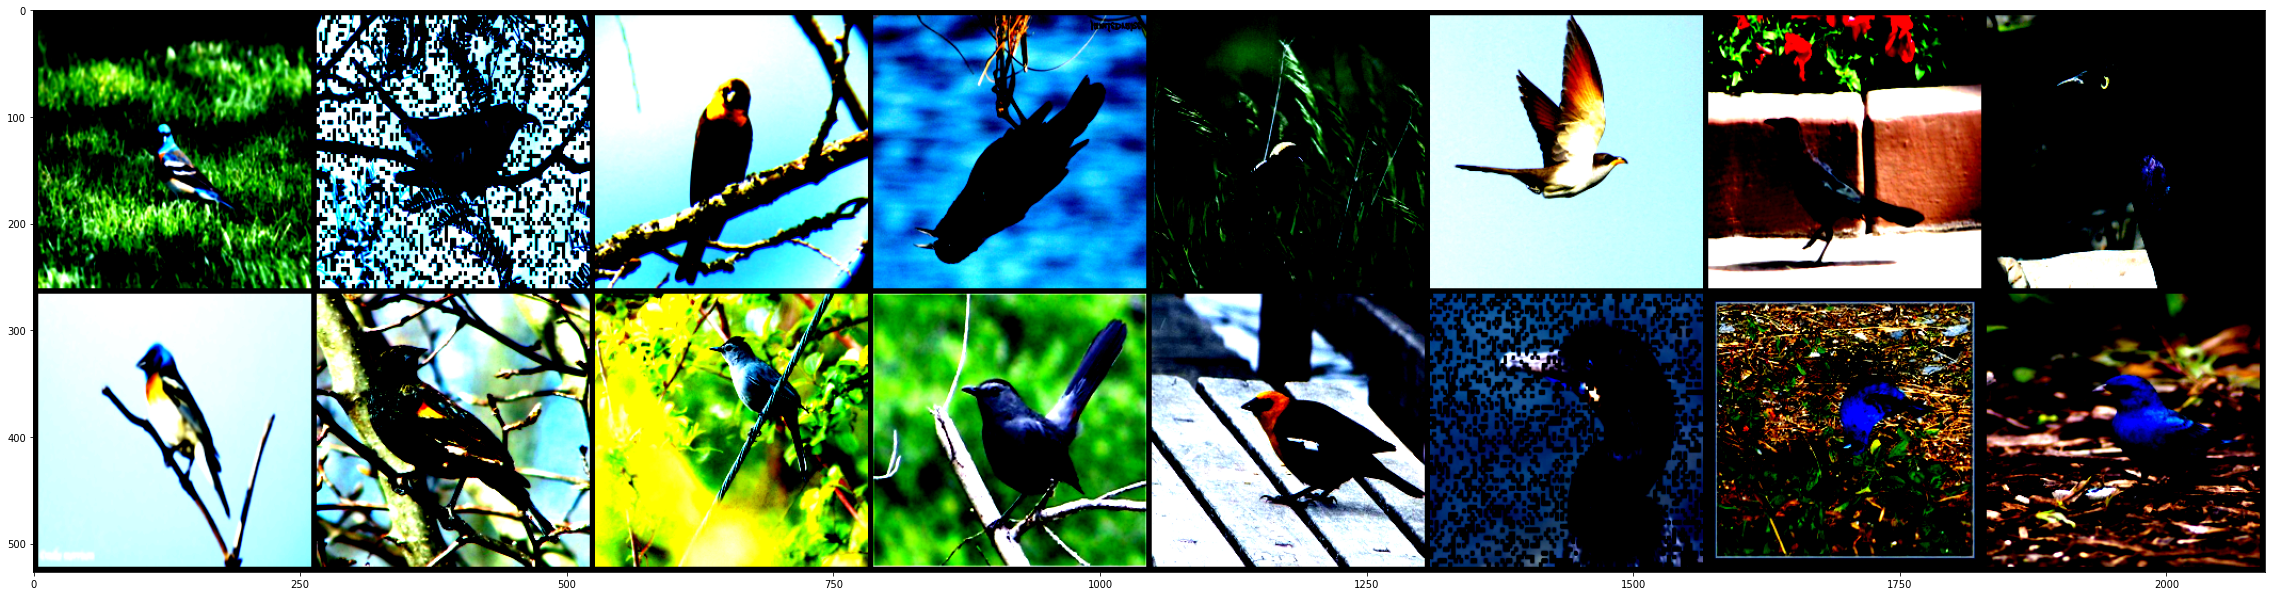

In [ ]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
fig = plt.figure(figsize = (40,15))
imshow(torchvision.utils.make_grid(images[0:16], padding=5))

#  Faster RCNN

In [ ]:
import argparse
import os
import numpy as np
import torch
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.utils import save_image

path2 = 'bird_dataset'

if not os.path.isdir(path + path2 + '/' + 'cropped_dataset'):
  os.mkdir('cropped_dataset')
os.chdir(path + path2)
for folder in os.walk(os.curdir):
    name = folder[0]
    if not os.path.isdir('../cropped_dataset'+ name[1:]):
        os.mkdir('../cropped_dataset'+ name[1:])

os.chdir('..')

for set in ['train', 'test', 'val']:

  data = datasets.ImageFolder(path2 +'/{}_images'.format(set), transform=transforms.ToTensor())
  modelObjDet = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  modelObjDet.cuda()

  loader = torch.utils.data.DataLoader(data,batch_size=1, shuffle=False)
  modelObjDet.eval()

  class_to_id = data.class_to_idx    
  id_to_class = {v: k for k, v in class_to_id.items()}  
  mapping = id_to_class


  for name, (data, target) in enumerate(loader):
    results = modelObjDet(data.cuda())
    for e, result in enumerate(results):
      boxes = result['boxes'].tolist()    # Bounding boxes
      labels =  result['labels'].tolist() # Labels
      scores = result['scores'].tolist()  # Confidence associated with bounding box
        
      # Keep only bird labels and boxes (label 16 in COCO)
      only_bird_boxes = np.array([boxes[i] for i in range(len(boxes)) if labels[i] == 16])
      only_birds_scores= np.array([scores[i] for i in range(len(boxes))  if labels[i] == 16])

      if not len(only_bird_boxes)==0:
        box = only_bird_boxes[e]
        a, b, c, d = int(box[0]), int(box[1]), int(box[2]), int(box[3])
        cropped = data[e, :, b:d, a:c] #cropped the image

        # Keep the name of the image for the evaluation on kaggle
        oldname = str(loader.dataset.samples[name]).split('/')[-1].split('jpg')[0]
        save_image(cropped, 'cropped_dataset/{}_images/'.format(set)+mapping[target[e].item()]+'/'+oldname+'png', format ='png')
      else :
        # if no bird is found --> keep the old image
        cropped = data[e, :, ::, ::]
        oldname = str(loader.dataset.samples[name]).split('/')[-1].split('jpg')[0]
        save_image(cropped, 'cropped_dataset/{}_images/'.format(set)+mapping[target[e].item()]+'/'+oldname+'png', format ='png')

In [ ]:
  path2 = 'bird_dataset'

# Load data cropped

In [ ]:
cd drive/MyDrive/recvis

/content/drive/MyDrive/recvis


In [ ]:
data_transforms = transforms.Compose([
    #augmentationTransform(),
    #transforms.ToPILImage(),
    transforms.Resize((256, 256), Image.BILINEAR),
    transforms.RandomHorizontalFlip(0.3),
    #transforms.RandomVerticalFlip(0.5),
    #transforms.RandomAdjustSharpness(0.7, p=0.5), 
    transforms.RandomRotation(degrees = 20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        
])


train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('cropped_dataset/train_images', transform=data_transforms),
    batch_size=batch_size, shuffle=True, num_workers=1)

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('cropped_dataset/val_images',transform=data_transforms),
    batch_size=batch_size, shuffle=True, num_workers=1)

test_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('cropped_dataset/test_images',transform=data_transforms),
    batch_size=1, shuffle=False, num_workers=1)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


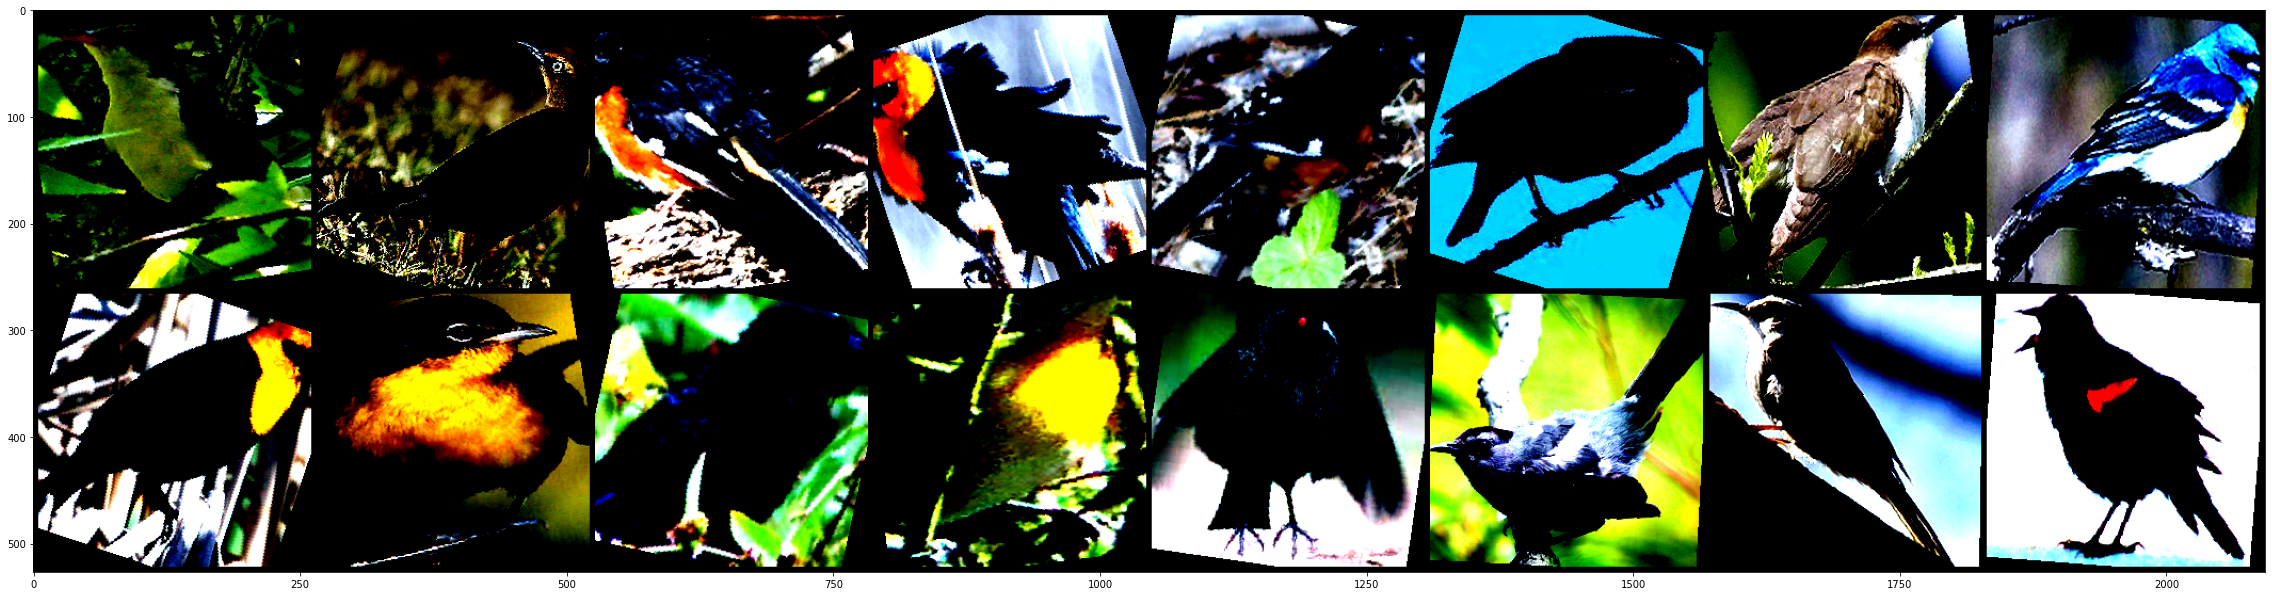

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
fig = plt.figure(figsize = (40,15))
imshow(torchvision.utils.make_grid(images[0:16], padding=5))

# Model

In [ ]:
nclasses = 20
import torch.nn.functional as F
from torchvision import models
from collections import namedtuple



class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(self.num_ftrs, nclasses)

    def forward(self, x):
        return self.model(x)

class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        self.model = models.resnet50(pretrained=True)
        self.num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(self.num_ftrs, nclasses)

    def forward(self, x):
        return self.model(x)

class ResNet152(nn.Module):
    def __init__(self):
        super(ResNet152, self).__init__()
        self.model = models.resnet152(pretrained=True)
        self.num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(self.num_ftrs, nclasses)

    def forward(self, x):
        return self.model(x)

In [ ]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]
            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        # Uncomment for LRfinder
        #return x, h
        return x


class Bottleneck(nn.Module):
    """Bottleneck block, used for ResNet50, ResNet101 and ResNet152."""
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
            
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x

ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

resnet152_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 8, 36, 3],
                                channels = [64, 128, 256, 512])

pretrained_model = models.resnet152(pretrained = True)

IN_FEATURES = pretrained_model.fc.in_features 
OUTPUT_DIM = nclasses 

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

# Replace the pre-trained model's linear layer with randomly initialized linear layer.
pretrained_model.fc = fc

# Initialize the model
model = ResNet(resnet152_config, OUTPUT_DIM)

# Load the parameters of the pre-trained model into our model.
model.load_state_dict(pretrained_model.state_dict())


START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler

class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()
            
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _ = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)


def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

Stopping early, the loss has diverged


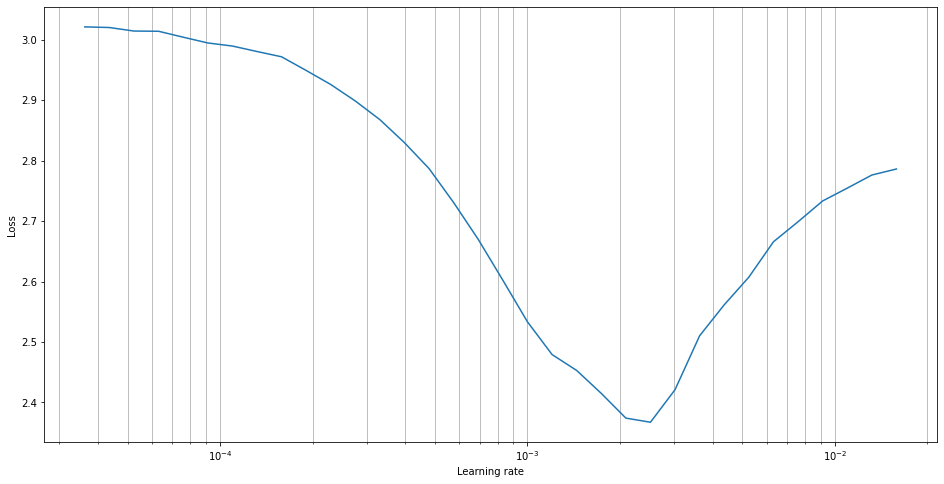

In [ ]:
END_LR = 10
NUM_ITER = 100

#### Uncomment in forward resnet if you want to plot lr_finder
lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_loader, END_LR, NUM_ITER)

plot_lr_finder(lrs, losses, skip_start = 30, skip_end = 30)

In [ ]:
FOUND_LR = 1e-3

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR * 2},
          {'params': model.fc.parameters()}
         ]

In [ ]:
#model = ResNet152()

if use_cuda:
    print('Using GPU')
    model.cuda()
else:
    print('Using CPU')
lr = 0.001

optimizer = optim.SGD(model.parameters(), lr=FOUND_LR, momentum=0.8)
#optimizer = optim.Adam(model.parameters(), lr=FOUND_LR)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

Using GPU


In [ ]:
EPOCHS = epochs
STEPS_PER_EPOCH = len(train_loader)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

# Train

In [ ]:
def train(model, epoch):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        #forward
        preds = model(data)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        if batch_idx % 25 == 0:
            print('[{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))


def validation(model):
    model.eval()
    validation_loss = 0
    correct = 0
    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            preds = model(data)
            # sum up batch loss
            validation_loss += criterion(preds, labels).data.item()
            m = nn.Softmax(dim=1)
            probs = m(preds)
            preds_classes = probs.max(1, keepdim=True)[1]
            correct += preds_classes.eq(labels.data.view_as(preds_classes)).sum()
        validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))

In [ ]:
for epoch in range(1, epochs + 1):
    print("################################################# EPOCH", epoch)
    train(model, epoch)
    preds = validation(model)
    model_file = 'experiments' + '/model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)

################################################# EPOCH 1
[0/1082 (0%)]	Loss: 0.270917
[500/1082 (45%)]	Loss: 0.245376
[1000/1082 (91%)]	Loss: 0.155436

Validation set: Average loss: 0.0194, Accuracy: 92/103 (89%)
################################################# EPOCH 2
[0/1082 (0%)]	Loss: 0.335171
[500/1082 (45%)]	Loss: 0.136928
[1000/1082 (91%)]	Loss: 0.252678

Validation set: Average loss: 0.0214, Accuracy: 87/103 (84%)
################################################# EPOCH 3
[0/1082 (0%)]	Loss: 0.214461
[500/1082 (45%)]	Loss: 0.271978
[1000/1082 (91%)]	Loss: 0.171250

Validation set: Average loss: 0.0234, Accuracy: 91/103 (88%)
################################################# EPOCH 4
[0/1082 (0%)]	Loss: 0.204896
[500/1082 (45%)]	Loss: 0.112596
[1000/1082 (91%)]	Loss: 0.162050

Validation set: Average loss: 0.0195, Accuracy: 91/103 (88%)
################################################# EPOCH 5
[0/1082 (0%)]	Loss: 0.159364
[500/1082 (45%)]	Loss: 0.382306
[1000/1082 (91%)]	Loss: 0

# Test

In [ ]:
preds = np.array([])
model.eval()
with torch.no_grad():
    for i, (data, labels) in tqdm(enumerate(test_loader, 0)):
        data, labels = data.to(device), labels.to(device)
        output1 = model(data)
        sm = nn.Softmax(dim=1)(output1)
        pred = sm.max(1, keepdim=True)[1]    
        preds = np.hstack((preds, torch.squeeze(pred).cpu().numpy()))

517it [00:18, 27.75it/s]


In [ ]:
f = open("submission.csv", "w")
f.write("Id,Category\n")
for (n,_),p in zip(test_loader.dataset.samples,preds):
    f.write("{},{}\n".format(n.split('/')[-1].split('.')[0], int(p)))
f.close()